### Exercício:

**Passo 1**: Escrever um digito qualquer numa folha de papel, tirar uma foto e subir pro PC.

**Passo 2**: Usar um modelo pré-treinado e e comparar os resultados com os números escritos. 

**Dica:** Faça os pré-processamentos que julgar necessários com o opencv e/ou numpy.

**Obs:** "Dígito" é um número de 0 a 9. O modelo não está treinado para entender que "12" signfica "doze", a base de treino contém apenas dígitos.

In [96]:
# importando as bibliotecas que serão utilizadas
import cv2
import numpy as np
from keras.models import load_model
import matplotlib.pyplot as plt

In [97]:
# função de visualização das imagens
def exibe_image(img, gray=True):
    plt.figure(figsize=(10, 20))
    if gray == True:
        plt.imshow(img, cmap = 'gray')
    else:
        plt.imshow(img)
    
    plt.axis('off')
    plt.show()

### Imagem utilizada

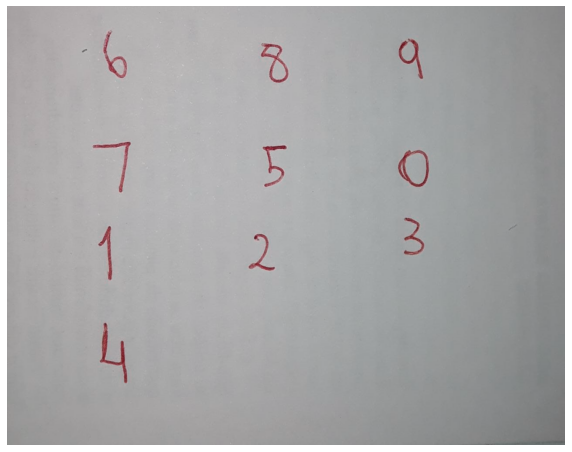

In [98]:
img = cv2.imread('digits.jpeg')
exibe_image(img)

### Funções criadas

In [99]:
def image_preprocessing(image_path):
    img = cv2.imread(image_path)
    img_cinza = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, img_bin = cv2.threshold(img_cinza, 120, 255, cv2.THRESH_BINARY_INV)
    
    # exibição da imagem para checagem do threshold
    print('Imagem após threshold', end='\n\n')
    exibe_image(img_bin)

    # processo de abertura para limpar a imagem
    opening = cv2.erode(img_bin, np.ones((3, 3), np.uint8))
    opening = cv2.dilate(opening, np.ones((8, 8), np.uint8))

    # exibição da imagem para checagem da abertura
    print('Imagem após o processo de abertura (erosão seguida de dilatação)')
    exibe_image(opening)

    return opening

In [100]:
# função para redimensionar as imagens de acordo com o padrão do modelo de rede neural
def resize_image(contorno, imagem):
    img_num = imagem.copy()
    x, y, larg, alt = cv2.boundingRect(contorno)
    num = img_num[y:y + alt, x:x + larg]
    num_resized = cv2.resize(num, (28, 28), interpolation=cv2.INTER_NEAREST)

    return num_resized

In [101]:
# função para formatar os dados de acordo com o padrão do modelo de rede neural
def format_data(data):
    formatted_data = np.array(data).astype('float32') // 255
    formatted_data = np.expand_dims(formatted_data, -1)
    return formatted_data

In [102]:
# Função para plotar as imagens
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(predicted_label,
                                100*np.max(predictions_array),
                                true_label),
                                color=color)

In [103]:
# Cria o gráfico com as probabilidades
def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

### Rodando o código completo

Imagem após threshold



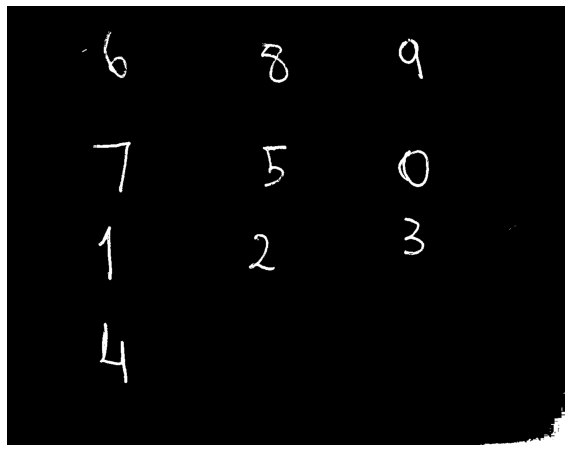

Imagem após o processo de abertura (erosão seguida de dilatação)


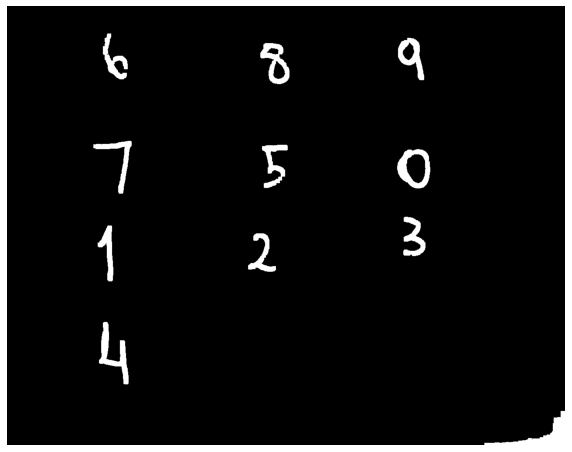

In [104]:
img_preprocessed = image_preprocessing('digits.jpeg')

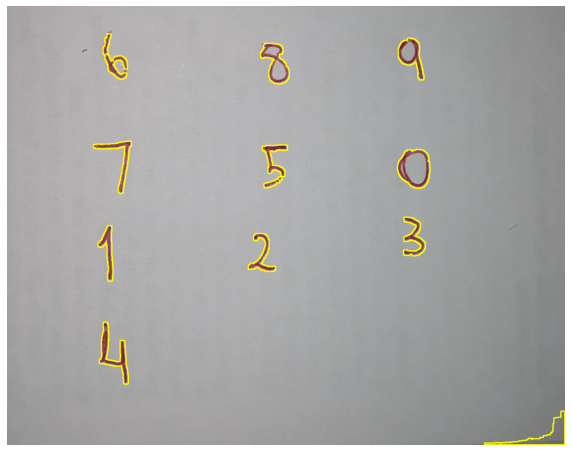

In [105]:
# contornos dos números
img_copy = img.copy()

contours, _ = cv2.findContours(img_preprocessed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# desenhando os contornos na imagem original
with_contour = cv2.drawContours(img_copy, contours, -1, (255, 255, 0), 2)
exibe_image(with_contour)

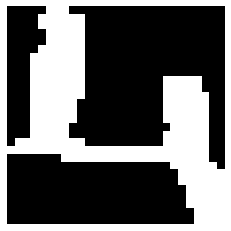

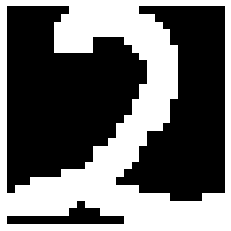

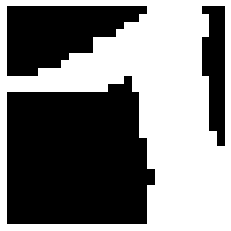

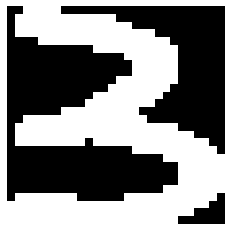

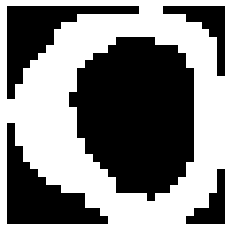

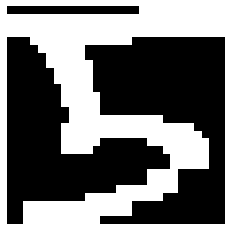

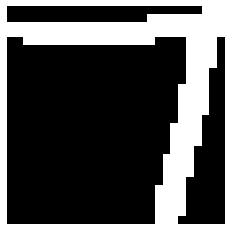

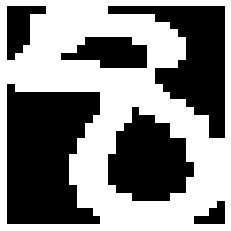

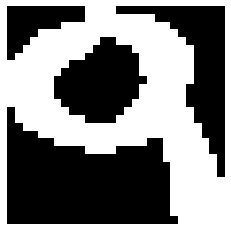

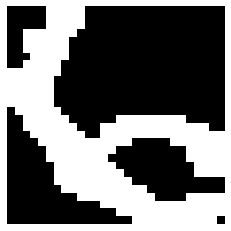

In [106]:
resized_nums = [resize_image(contorno, img_preprocessed) for contorno in contours[1:]]

for nums in resized_nums:
    plt.imshow(nums, cmap='gray')
    plt.axis('off')
    plt.show()

In [107]:
# formatando as imagens para compatibilizá-las com o modelo de Rede Neural
formatted_nums = format_data(resized_nums)

In [108]:
# carregando o modelo pré-treinado
model = load_model('model_digito.h5')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 1600)              0         
                                                                 
 dropout (Dropout)           (None, 1600)             

In [109]:
# predição do modelo
pred = model.predict(formatted_nums)

In [110]:
# lista com os valores corretos para comparação nos gráficos
true_label = [4, 2, 1, 3, 0, 5, 7, 8, 9, 6]

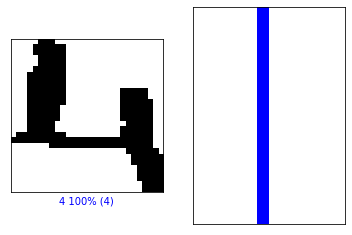

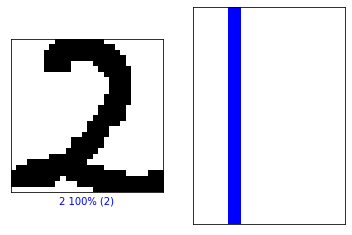

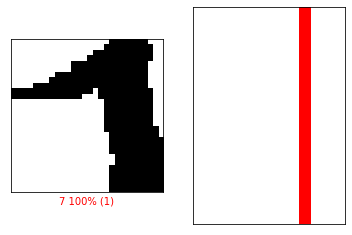

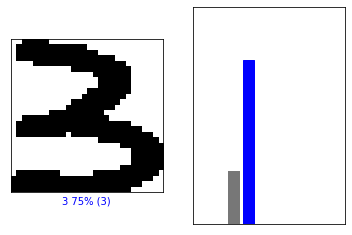

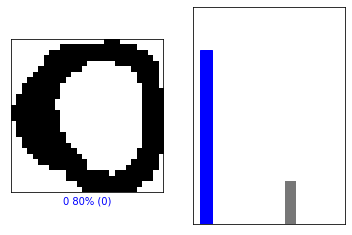

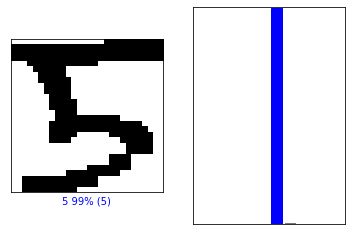

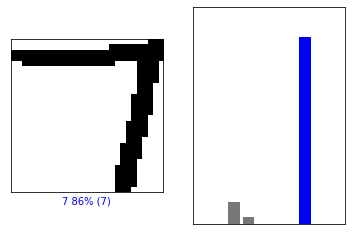

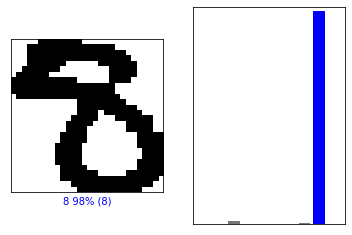

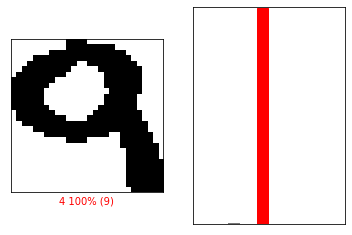

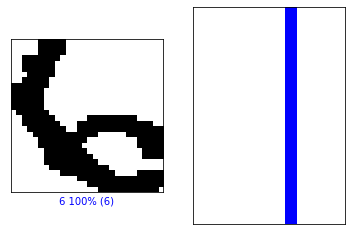

In [111]:
for i in range(len(pred)):
    plt.subplot(1, 2, 1)
    plot_image(i, pred, true_label, formatted_nums[:,:,:,0])
    plt.subplot(1, 2, 2)
    plot_value_array(i, pred,  true_label)
    plt.show()

In [112]:
pred_labels = np.argmax(pred, axis = -1)
pred_labels

array([4, 2, 7, 3, 0, 5, 7, 8, 4, 6], dtype=int64)

In [113]:
from sklearn.metrics import accuracy_score

print(f'Acurácia: {accuracy_score(true_label, pred_labels):.1%}')

Acurácia: 80.0%


### Conclusão

O modelo previu corretamente a maioria dos números, ocorrendo apenas 2 erros em 10 previsões. O primeiro erro ocorreu no caso do número um, em que a previsão pode ter sido incorreta por conta da sua semelhança com o número sete, a depender da grafia. Além disso, o número um não possui o "chapeuzinho" nos samples da base de treino. Já o número nove tem semelhanças com o número quatro, mas a previsão não deixa de causar estranhamento. Na minha concepção, o modelo de Rede Neural poderia prever melhor esses casos, já que a imagem estudada contém uma grafia muito comum dos números.